In [1]:
import darts
import numpy as np
from darts.models.forecasting.block_rnn_model import BlockRNNModel
from darts.dataprocessing.transformers import Scaler
import pandas as pd
from datetime import datetime
import tracestack
tracestack.off()
import optuna
import joblib

Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv("C:\\Users\\Magic\\Downloads\\EURUSD_Candlestick_1_D_BID_01.01.1990-01.01.2022 (1).csv", delimiter=",")

In [3]:
print(df)

                      Gmt time     Open     High      Low    Close      Volume
0      01.01.1990 00:00:00.000  1.15610  1.15610  1.15610  1.15610      0.0000
1      02.01.1990 00:00:00.000  1.16060  1.16450  1.14020  1.14020  11639.4688
2      03.01.1990 00:00:00.000  1.14440  1.14440  1.13380  1.13500  18652.9941
3      04.01.1990 00:00:00.000  1.13300  1.17040  1.12690  1.16720  12534.8125
4      05.01.1990 00:00:00.000  1.15920  1.16630  1.15100  1.16060   6565.8540
...                        ...      ...      ...      ...      ...         ...
11684  28.12.2021 00:00:00.000  1.13293  1.13331  1.12895  1.13130  44411.8477
11685  29.12.2021 00:00:00.000  1.13131  1.13688  1.12737  1.13595  66789.9375
11686  30.12.2021 00:00:00.000  1.13595  1.13597  1.12984  1.13222  55366.0586
11687  31.12.2021 00:00:00.000  1.13219  1.13863  1.13032  1.13667  48312.0703
11688  01.01.2022 00:00:00.000  1.13667  1.13667  1.13667  1.13667      0.0000

[11689 rows x 6 columns]


In [4]:
del df['Open'], df['High'], df['Low'], df['Volume']

In [5]:
print(df)

                      Gmt time    Close
0      01.01.1990 00:00:00.000  1.15610
1      02.01.1990 00:00:00.000  1.14020
2      03.01.1990 00:00:00.000  1.13500
3      04.01.1990 00:00:00.000  1.16720
4      05.01.1990 00:00:00.000  1.16060
...                        ...      ...
11684  28.12.2021 00:00:00.000  1.13130
11685  29.12.2021 00:00:00.000  1.13595
11686  30.12.2021 00:00:00.000  1.13222
11687  31.12.2021 00:00:00.000  1.13667
11688  01.01.2022 00:00:00.000  1.13667

[11689 rows x 2 columns]


<AxesSubplot:>

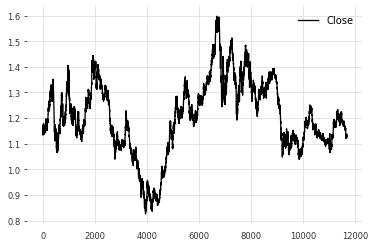

In [6]:
df.plot()

In [7]:
df.drop_duplicates(subset="Gmt time",keep ="first", inplace =True)
print(df)

                      Gmt time    Close
0      01.01.1990 00:00:00.000  1.15610
1      02.01.1990 00:00:00.000  1.14020
2      03.01.1990 00:00:00.000  1.13500
3      04.01.1990 00:00:00.000  1.16720
4      05.01.1990 00:00:00.000  1.16060
...                        ...      ...
11684  28.12.2021 00:00:00.000  1.13130
11685  29.12.2021 00:00:00.000  1.13595
11686  30.12.2021 00:00:00.000  1.13222
11687  31.12.2021 00:00:00.000  1.13667
11688  01.01.2022 00:00:00.000  1.13667

[11689 rows x 2 columns]


<AxesSubplot:>

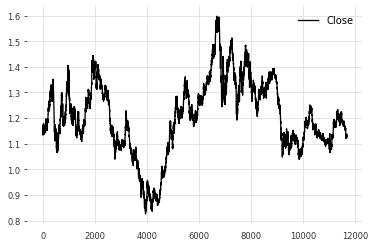

In [8]:
df.plot()

In [9]:
print(len(df))

11689


In [10]:
series = darts.timeseries.TimeSeries.from_dataframe(df,time_col ='Gmt time')

In [11]:
print(series[:10])

<TimeSeries (DataArray) (Gmt time: 10, component: 1, sample: 1)>
array([[[1.1561]],

       [[1.1668]],

       [[1.1373]],

       [[1.1547]],

       [[1.1637]],

       [[1.1508]],

       [[1.1779]],

       [[1.2312]],

       [[1.2521]],

       [[1.258 ]]])
Coordinates:
  * Gmt time   (Gmt time) datetime64[ns] 1990-01-01 1990-01-02 ... 1990-01-10
  * component  (component) object 'Close'
Dimensions without coordinates: sample


<AxesSubplot:>

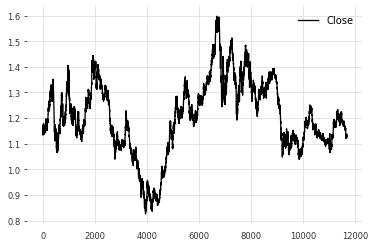

In [12]:
df.plot()

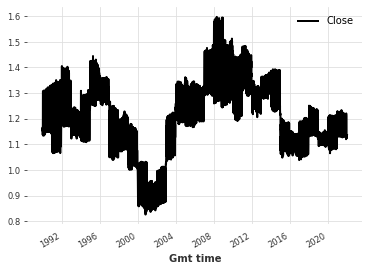

In [13]:
series.plot()

In [14]:
train, series1 = series[:9689], series[9689:] 
print(len(train), len(series1))

9689 2000


In [15]:
val,test = series1[:1000], series1[1000:]
print(len(train), len(val), len(test))

9689 1000 1000


In [16]:
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
test_transformed = transformer.transform(test)
series1_transformed = transformer.transform(series1)

In [17]:
print(train_transformed)

<TimeSeries (DataArray) (Gmt time: 9689, component: 1, sample: 1)>
array([[[0.42773187]],

       [[0.44161337]],

       [[0.40334194]],

       ...,

       [[0.38584087]],

       [[0.3804699 ]],

       [[0.36130823]]])
Coordinates:
  * Gmt time   (Gmt time) datetime64[ns] 1990-01-01 1990-01-02 ... 2016-07-11
  * component  (component) object 'Close'
Dimensions without coordinates: sample


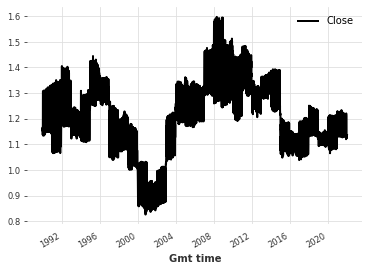

In [18]:
series.plot()

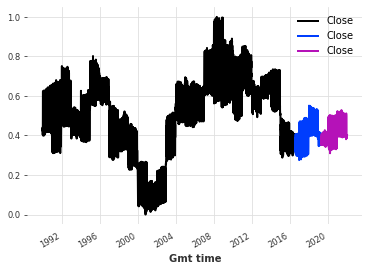

In [19]:
train_transformed.plot()
val_transformed.plot()
test_transformed.plot()

In [20]:
from darts.utils.likelihood_models import BernoulliLikelihood
from darts.utils.likelihood_models import CauchyLikelihood
from darts.utils.likelihood_models import ContinuousBernoulliLikelihood
from darts.utils.likelihood_models import DirichletLikelihood

In [21]:
from darts.models.forecasting.block_rnn_model import BlockRNNModel

#train_transformed.plot()
print(val_transformed[:1])
def objective(trial):

    param = {
        "input_chunk_length": 100,
       # "likelihood": trial.suggest_categorical("likelihood", [CauchyLikelihood, ContinuousBernoulliLikelihood]),
        "optimizer_kwargs": trial.suggest_categorical("optimizer_kwargs", [{'lr': 1e-5}, {'lr': 1e-4}, {'lr': 1e-3},{'lr': 1e-2}, {'lr': 1e-1}, {'lr': 1e-0}]),
        "model": trial.suggest_categorical("model", ["RNN", "LSTM", "GRU"]),
        "dropout": trial.suggest_float("dropout", 0.1, 0.9, log=True),
        "hidden_size": trial.suggest_int("hidden_size", 1, 50),
        "n_rnn_layers": trial.suggest_int("n_rnn_layers", 1, 10),
        "random_state": trial.suggest_int("random_state", 5, 1000),
        "n_epochs": 10,
        "force_reset": True,
        "work_dir": "C:\Windows\System32\####python program\blockrnn darts backup"

#"n_epochs": trail.suggest_categorical("n_epochs", [5,10,50,100,300,500,750,1000])
    }
    model = BlockRNNModel(**param, output_chunk_length= 1)
    # Training the model on the complete training set
    model.fit(val_transformed)
    
    # Evaluating the model on the validation set
    pred = model.predict(n=1)
    #val_transformed.plot()
    print(pred)
                                              
    mse = darts.metrics.metrics.mse(actual_series = test_transformed, pred_series = pred)
    accuracy = mse
    return accuracy

<TimeSeries (DataArray) (Gmt time: 1, component: 1, sample: 1)>
array([[[0.32371142]]])
Coordinates:
  * Gmt time   (Gmt time) datetime64[ns] 2016-07-12
  * component  (component) object 'Close'
Dimensions without coordinates: sample


In [22]:
import logging
import sys

import optuna

# Add stream handler of stdout to show the messages
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "blockrnn"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, storage=storage_name)

[I 2022-01-06 18:17:34,888] A new study created in RDB with name: blockrnn


A new study created in RDB with name: blockrnn


In [23]:
if __name__ == "__main__":
    #study = optuna.create_study(direction="maximize")
    #joblib.dump(study, "C:\Windows\System32\####python program\model checkpoint\Blockrnn\study blockrnn\study.pkl")
    #study = joblib.load("C:\Windows\System32\####python program\model checkpoint\Blockrnn\study blockrnn/study.pkl")
    study.optimize(objective, n_trials=50)

    print("Number of finished trials: {}".format(len(study.trials)))

   # print("Best trial:")
    #trial = study.best_trial
    

   # print("  Value: {}".format(trial.value))

    #print("  Params: ")
    #for key, value in trial.params.items():
    #    print("    {}: {}".format(key, value))


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.03449852]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 0 finished with value: 0.11182277918459631 and parameters: {'optimizer_kwargs': {'lr': 1e-05}, 'model': 'LSTM', 'dropout': 0.16758932768422505, 'hidden_size': 25, 'n_rnn_layers': 4, 'random_state': 87}. Best is trial 0 with value: 0.11182277918459631.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.43225437]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 1 finished with value: 0.0040140738424441665 and parameters: {'optimizer_kwargs': {'lr': 0.001}, 'model': 'LSTM', 'dropout': 0.495971679242641, 'hidden_size': 27, 'n_rnn_layers': 10, 'random_state': 545}. Best is trial 1 with value: 0.0040140738424441665.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.41367149]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 2 finished with value: 0.002004696690737777 and parameters: {'optimizer_kwargs': {'lr': 1e-05}, 'model': 'RNN', 'dropout': 0.2131568701212938, 'hidden_size': 37, 'n_rnn_layers': 10, 'random_state': 187}. Best is trial 2 with value: 0.002004696690737777.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.39674726]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 3 finished with value: 0.0007756003665479282 and parameters: {'optimizer_kwargs': {'lr': 1.0}, 'model': 'LSTM', 'dropout': 0.15457545978327986, 'hidden_size': 3, 'n_rnn_layers': 10, 'random_state': 497}. Best is trial 3 with value: 0.0007756003665479282.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.07356707]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 4 finished with value: 0.08722015329828102 and parameters: {'optimizer_kwargs': {'lr': 1e-05}, 'model': 'GRU', 'dropout': 0.5686834845748561, 'hidden_size': 39, 'n_rnn_layers': 8, 'random_state': 772}. Best is trial 3 with value: 0.0007756003665479282.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[-0.26658352]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 5 finished with value: 0.4038363252015631 and parameters: {'optimizer_kwargs': {'lr': 1e-05}, 'model': 'RNN', 'dropout': 0.20901880588884705, 'hidden_size': 6, 'n_rnn_layers': 4, 'random_state': 549}. Best is trial 3 with value: 0.0007756003665479282.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.41977934]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 6 finished with value: 0.002588945724812594 and parameters: {'optimizer_kwargs': {'lr': 0.0001}, 'model': 'LSTM', 'dropout': 0.22788918956150667, 'hidden_size': 39, 'n_rnn_layers': 7, 'random_state': 61}. Best is trial 3 with value: 0.0007756003665479282.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.16432032]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 7 finished with value: 0.04185188406332513 and parameters: {'optimizer_kwargs': {'lr': 0.0001}, 'model': 'GRU', 'dropout': 0.5563983170367115, 'hidden_size': 4, 'n_rnn_layers': 2, 'random_state': 341}. Best is trial 3 with value: 0.0007756003665479282.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.42523441]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 8 finished with value: 0.0031738301712038973 and parameters: {'optimizer_kwargs': {'lr': 0.0001}, 'model': 'RNN', 'dropout': 0.3289242857374506, 'hidden_size': 3, 'n_rnn_layers': 9, 'random_state': 964}. Best is trial 3 with value: 0.0007756003665479282.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.47312387]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 9 finished with value: 0.010863104620960285 and parameters: {'optimizer_kwargs': {'lr': 1.0}, 'model': 'GRU', 'dropout': 0.7181319402249717, 'hidden_size': 18, 'n_rnn_layers': 9, 'random_state': 312}. Best is trial 3 with value: 0.0007756003665479282.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.4049161]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 10 finished with value: 0.0012973282563672524 and parameters: {'optimizer_kwargs': {'lr': 1.0}, 'model': 'LSTM', 'dropout': 0.11550387932209, 'hidden_size': 14, 'n_rnn_layers': 6, 'random_state': 748}. Best is trial 3 with value: 0.0007756003665479282.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.37854347]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 11 finished with value: 9.304184339671994e-05 and parameters: {'optimizer_kwargs': {'lr': 1.0}, 'model': 'LSTM', 'dropout': 0.10013261979759995, 'hidden_size': 13, 'n_rnn_layers': 6, 'random_state': 745}. Best is trial 11 with value: 9.304184339671994e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.44703419]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 12 finished with value: 0.006105317965097832 and parameters: {'optimizer_kwargs': {'lr': 1.0}, 'model': 'LSTM', 'dropout': 0.10677905363065313, 'hidden_size': 13, 'n_rnn_layers': 1, 'random_state': 668}. Best is trial 11 with value: 9.304184339671994e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.41719903]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 13 finished with value: 0.002333023447839796 and parameters: {'optimizer_kwargs': {'lr': 0.1}, 'model': 'LSTM', 'dropout': 0.1420571149135368, 'hidden_size': 10, 'n_rnn_layers': 5, 'random_state': 940}. Best is trial 11 with value: 9.304184339671994e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.41503042]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 14 finished with value: 0.0021282325223062333 and parameters: {'optimizer_kwargs': {'lr': 0.01}, 'model': 'LSTM', 'dropout': 0.10361445648991359, 'hidden_size': 49, 'n_rnn_layers': 7, 'random_state': 399}. Best is trial 11 with value: 9.304184339671994e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.42161775]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 15 finished with value: 0.0027794083514163853 and parameters: {'optimizer_kwargs': {'lr': 1.0}, 'model': 'LSTM', 'dropout': 0.1501689229582646, 'hidden_size': 21, 'n_rnn_layers': 3, 'random_state': 647}. Best is trial 11 with value: 9.304184339671994e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.46460258]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 16 finished with value: 0.009159432492038771 and parameters: {'optimizer_kwargs': {'lr': 1.0}, 'model': 'LSTM', 'dropout': 0.2797224461440571, 'hidden_size': 8, 'n_rnn_layers': 6, 'random_state': 846}. Best is trial 11 with value: 9.304184339671994e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.41584969]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 17 finished with value: 0.002204494058309381 and parameters: {'optimizer_kwargs': {'lr': 0.01}, 'model': 'LSTM', 'dropout': 0.13931934654228587, 'hidden_size': 1, 'n_rnn_layers': 7, 'random_state': 453}. Best is trial 11 with value: 9.304184339671994e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.43729205]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 18 finished with value: 0.0046777930486145095 and parameters: {'optimizer_kwargs': {'lr': 0.001}, 'model': 'GRU', 'dropout': 0.33333969767114796, 'hidden_size': 17, 'n_rnn_layers': 9, 'random_state': 651}. Best is trial 11 with value: 9.304184339671994e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.39967111]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 19 finished with value: 0.0009470057512840356 and parameters: {'optimizer_kwargs': {'lr': 0.1}, 'model': 'RNN', 'dropout': 0.17777173263446616, 'hidden_size': 29, 'n_rnn_layers': 5, 'random_state': 269}. Best is trial 11 with value: 9.304184339671994e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.44209835]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 20 finished with value: 0.005358341901221887 and parameters: {'optimizer_kwargs': {'lr': 1.0}, 'model': 'LSTM', 'dropout': 0.12903903112879317, 'hidden_size': 10, 'n_rnn_layers': 8, 'random_state': 481}. Best is trial 11 with value: 9.304184339671994e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.37598438]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 21 finished with value: 5.022176663626766e-05 and parameters: {'optimizer_kwargs': {'lr': 0.1}, 'model': 'RNN', 'dropout': 0.1796335376819588, 'hidden_size': 24, 'n_rnn_layers': 5, 'random_state': 259}. Best is trial 21 with value: 5.022176663626766e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.41380121]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 22 finished with value: 0.0020163293388886123 and parameters: {'optimizer_kwargs': {'lr': 0.1}, 'model': 'RNN', 'dropout': 0.17337503019221134, 'hidden_size': 20, 'n_rnn_layers': 4, 'random_state': 184}. Best is trial 21 with value: 5.022176663626766e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.59825435]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 23 finished with value: 0.0526044950686522 and parameters: {'optimizer_kwargs': {'lr': 0.1}, 'model': 'RNN', 'dropout': 0.2558756227652126, 'hidden_size': 30, 'n_rnn_layers': 3, 'random_state': 208}. Best is trial 21 with value: 5.022176663626766e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.54684182]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 24 finished with value: 0.031664127099280175 and parameters: {'optimizer_kwargs': {'lr': 1.0}, 'model': 'RNN', 'dropout': 0.12272514215122474, 'hidden_size': 23, 'n_rnn_layers': 6, 'random_state': 589}. Best is trial 21 with value: 5.022176663626766e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.38818162]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 25 finished with value: 0.0003718715076130787 and parameters: {'optimizer_kwargs': {'lr': 0.1}, 'model': 'RNN', 'dropout': 0.41523956651908694, 'hidden_size': 14, 'n_rnn_layers': 5, 'random_state': 381}. Best is trial 21 with value: 5.022176663626766e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.39852833]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 26 finished with value: 0.0008779770747071369 and parameters: {'optimizer_kwargs': {'lr': 0.1}, 'model': 'RNN', 'dropout': 0.42909866672516866, 'hidden_size': 14, 'n_rnn_layers': 5, 'random_state': 407}. Best is trial 21 with value: 5.022176663626766e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.51422991]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 27 finished with value: 0.02112146528114343 and parameters: {'optimizer_kwargs': {'lr': 0.1}, 'model': 'RNN', 'dropout': 0.3825356876904714, 'hidden_size': 35, 'n_rnn_layers': 3, 'random_state': 129}. Best is trial 21 with value: 5.022176663626766e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.69585584]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 28 finished with value: 0.10690165765908975 and parameters: {'optimizer_kwargs': {'lr': 0.1}, 'model': 'RNN', 'dropout': 0.8531542175595657, 'hidden_size': 32, 'n_rnn_layers': 5, 'random_state': 14}. Best is trial 21 with value: 5.022176663626766e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.44576063]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 29 finished with value: 0.0059079171229100835 and parameters: {'optimizer_kwargs': {'lr': 0.1}, 'model': 'RNN', 'dropout': 0.19411796315854318, 'hidden_size': 25, 'n_rnn_layers': 4, 'random_state': 267}. Best is trial 21 with value: 5.022176663626766e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.37328077]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 30 finished with value: 1.9211737490781205e-05 and parameters: {'optimizer_kwargs': {'lr': 0.001}, 'model': 'RNN', 'dropout': 0.24905093829243072, 'hidden_size': 17, 'n_rnn_layers': 6, 'random_state': 391}. Best is trial 30 with value: 1.9211737490781205e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.41129746]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 31 finished with value: 0.0017977438597909605 and parameters: {'optimizer_kwargs': {'lr': 0.001}, 'model': 'RNN', 'dropout': 0.2710340910468646, 'hidden_size': 17, 'n_rnn_layers': 6, 'random_state': 369}. Best is trial 30 with value: 1.9211737490781205e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.4115229]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 32 finished with value: 0.001816911530132966 and parameters: {'optimizer_kwargs': {'lr': 0.001}, 'model': 'RNN', 'dropout': 0.41405565780838877, 'hidden_size': 25, 'n_rnn_layers': 7, 'random_state': 278}. Best is trial 30 with value: 1.9211737490781205e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.41265937]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 33 finished with value: 0.0019150881995798838 and parameters: {'optimizer_kwargs': {'lr': 0.001}, 'model': 'RNN', 'dropout': 0.2355413271849549, 'hidden_size': 13, 'n_rnn_layers': 4, 'random_state': 394}. Best is trial 30 with value: 1.9211737490781205e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.38186807]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 34 finished with value: 0.00016823168909317894 and parameters: {'optimizer_kwargs': {'lr': 0.001}, 'model': 'RNN', 'dropout': 0.32345090411080785, 'hidden_size': 20, 'n_rnn_layers': 5, 'random_state': 573}. Best is trial 30 with value: 1.9211737490781205e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.41121865]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 35 finished with value: 0.0017910665431306596 and parameters: {'optimizer_kwargs': {'lr': 0.001}, 'model': 'RNN', 'dropout': 0.34281823070742545, 'hidden_size': 21, 'n_rnn_layers': 6, 'random_state': 725}. Best is trial 30 with value: 1.9211737490781205e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.37588841]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 36 finished with value: 4.8870613621951893e-05 and parameters: {'optimizer_kwargs': {'lr': 0.001}, 'model': 'GRU', 'dropout': 0.3012815202258855, 'hidden_size': 28, 'n_rnn_layers': 8, 'random_state': 555}. Best is trial 30 with value: 1.9211737490781205e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.42130853]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 37 finished with value: 0.00274690040649716 and parameters: {'optimizer_kwargs': {'lr': 0.001}, 'model': 'GRU', 'dropout': 0.19827097828861828, 'hidden_size': 27, 'n_rnn_layers': 8, 'random_state': 842}. Best is trial 30 with value: 1.9211737490781205e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.05634268]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 38 finished with value: 0.09769061191086023 and parameters: {'optimizer_kwargs': {'lr': 1e-05}, 'model': 'GRU', 'dropout': 0.23935704922864415, 'hidden_size': 43, 'n_rnn_layers': 8, 'random_state': 523}. Best is trial 30 with value: 1.9211737490781205e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.41164608]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 39 finished with value: 0.00182742778903288 and parameters: {'optimizer_kwargs': {'lr': 0.001}, 'model': 'GRU', 'dropout': 0.1626442672542511, 'hidden_size': 28, 'n_rnn_layers': 7, 'random_state': 455}. Best is trial 30 with value: 1.9211737490781205e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.43758277]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 40 finished with value: 0.004717645518019201 and parameters: {'optimizer_kwargs': {'lr': 0.0001}, 'model': 'GRU', 'dropout': 0.5113278082549317, 'hidden_size': 33, 'n_rnn_layers': 10, 'random_state': 149}. Best is trial 30 with value: 1.9211737490781205e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.4235893]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 41 finished with value: 0.002991175878926234 and parameters: {'optimizer_kwargs': {'lr': 0.001}, 'model': 'GRU', 'dropout': 0.3108132145736816, 'hidden_size': 23, 'n_rnn_layers': 5, 'random_state': 567}. Best is trial 30 with value: 1.9211737490781205e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.41865553]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 42 finished with value: 0.0024758467789369664 and parameters: {'optimizer_kwargs': {'lr': 0.001}, 'model': 'RNN', 'dropout': 0.2982753276740374, 'hidden_size': 19, 'n_rnn_layers': 6, 'random_state': 602}. Best is trial 30 with value: 1.9211737490781205e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.41527827]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 43 finished with value: 0.002151161517642896 and parameters: {'optimizer_kwargs': {'lr': 0.001}, 'model': 'RNN', 'dropout': 0.37446962474369605, 'hidden_size': 16, 'n_rnn_layers': 7, 'random_state': 807}. Best is trial 30 with value: 1.9211737490781205e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.03125182]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 44 finished with value: 0.11400471037240392 and parameters: {'optimizer_kwargs': {'lr': 1e-05}, 'model': 'GRU', 'dropout': 0.21428869653069474, 'hidden_size': 23, 'n_rnn_layers': 4, 'random_state': 514}. Best is trial 30 with value: 1.9211737490781205e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.41507532]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 45 finished with value: 0.0021323770630078988 and parameters: {'optimizer_kwargs': {'lr': 0.01}, 'model': 'LSTM', 'dropout': 0.27056143880503136, 'hidden_size': 26, 'n_rnn_layers': 9, 'random_state': 672}. Best is trial 30 with value: 1.9211737490781205e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.42051867]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 46 finished with value: 0.002664729357869113 and parameters: {'optimizer_kwargs': {'lr': 0.001}, 'model': 'RNN', 'dropout': 0.2953909384005975, 'hidden_size': 7, 'n_rnn_layers': 6, 'random_state': 325}. Best is trial 30 with value: 1.9211737490781205e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.40822318]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 47 finished with value: 0.0015464966714389353 and parameters: {'optimizer_kwargs': {'lr': 0.0001}, 'model': 'GRU', 'dropout': 0.4590614553974799, 'hidden_size': 11, 'n_rnn_layers': 5, 'random_state': 699}. Best is trial 30 with value: 1.9211737490781205e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.43095773]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 48 finished with value: 0.003851453257338991 and parameters: {'optimizer_kwargs': {'lr': 0.001}, 'model': 'LSTM', 'dropout': 0.35939553858999274, 'hidden_size': 31, 'n_rnn_layers': 8, 'random_state': 900}. Best is trial 30 with value: 1.9211737490781205e-05.


C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 1e-05} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.0001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'lr': 0.001} which is of type dict.
  warnings.warn(message)
C:\Users\Magic\anaconda3\envs\work\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a t

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)>
array([[[0.36661406]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-04-08
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Trial 49 finished with value: 5.214814865115338e-06 and parameters: {'optimizer_kwargs': {'lr': 1.0}, 'model': 'RNN', 'dropout': 0.24581692470306724, 'hidden_size': 16, 'n_rnn_layers': 2, 'random_state': 619}. Best is trial 49 with value: 5.214814865115338e-06.
Number of finished trials: 50


In [24]:
#study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True)
#study.optimize(objective, n_trials=3)

In [ ]:
#study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True)
#df = study.trials_dataframe(attrs=("number", "value", "params", "state"))

In [ ]:
#print(df)

In [ ]:
#print("Best params: ", study.best_params)


In [ ]:
#print("Best value: ", study.best_value)

In [ ]:
#print("Best Trial: ", study.best_trial)

In [ ]:
#print("Trials: ", study.trials)

In [22]:
print(len(val_transformed))

5000


[2022-01-05 20:32:02,421] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 900 samples.
[2022-01-05 20:32:02,421] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 900 samples.
[2022-01-05 20:32:02,431] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-01-05 20:32:02,431] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


Wall time: 57min 45s


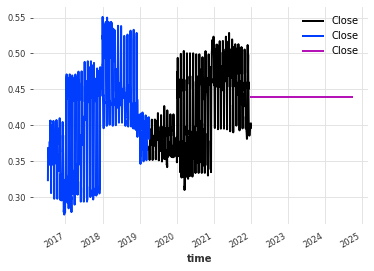

In [62]:
%%time
model = BlockRNNModel(input_chunk_length =100, 
                      output_chunk_length= 1, 
                      model= "LSTM", 
                      dropout= 0.5674480512117217, 
                      hidden_size= 50,
                      n_rnn_layers= 20,
                      random_state= 18,
                     )
# Training the model on the complete training set
model.fit(val_transformed)

# Evaluating the model on the validation set
pred = model.predict(n=1000)
val_transformed.plot()
test_transformed.plot()
pred.plot()
    
 # n_epochs =10